## Longitudinal motion


Useful link (however the formulas used are not included here): http://kli.web.cern.ch/kli/USPAS_Lectures_Collective_Effects/Lectures/USPAS_01c_longitudinal_dynamics.pdf

In [6]:
import sys
from math import *
import numpy as np
import pandas as pd
from dotted_dict import DottedDict
import matplotlib.pyplot as plt

### Plotting parameters

In [11]:
params = {'legend.fontsize': 25,
          'figure.figsize': (8.5, 6.5),
          'axes.labelsize': 25,
          'axes.titlesize': 25,
          'xtick.labelsize': 25,
          'ytick.labelsize': 25,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

### Constants

In [12]:
m0 = 0.9382720813 # proton rest mass, [GeV/c^2] 
c = 299792458 # speed of light [m/s]
C0 = 26658.8832 # LHC circumference MAD-X twiss, [m]   , alternively use 26659 [m]
q  = 1.602176565e-19 # [C]

### Parameters of the reference particle

In [13]:
E_rest = m0 # [GeV]
E_0 = 7000. # total energy of the reference particle [GeV]
P0 = np.sqrt(E_0**2-E_rest**2)  # reference momentum times the speed of ligth, [GeV/c]
gamma_0 =  E_0/E_rest # gamma realtivistic of the reference particle  # crosscheckd with mad
beta_0 = np.sqrt(1-1/gamma_0**2) # beta realtivistic of the reference particle
f_rev_0 = (beta_0*c)/C0 # revolution frequency [Hz]
T_rev_0 = 1/f_rev_0 # revolution period [s]

# Calculate the harmonic number

### Test for a particle with given momentum deviation
- Calculate the relativistic beta for a particle with delta specified by the user

In [14]:
delta = 1e-4

In [15]:
P = (1 + delta) * P0 # GeV/c
gamma = np.sqrt(1+(P/m0)**2)
beta = np.sqrt(1-1/gamma**2)

In [16]:
'The relativistic beta for a particle with delta = {} is {}'.format(delta, beta)

'The relativistic beta for a particle with delta = 0.0001 is 0.9999999910185872'

In [17]:
def drift(eta, alpha_c, C0, z, delta):
    z1 =z - eta * delta * C0
    delta1 = delta
    
    return z1, delta1

In [23]:
def RF_map(P0, m0, beta_0, f_RF, c, lag, V_RF, E_0, z, delta):
    
    P = (1 + delta) * P0 # GeV/c
    gamma = np.sqrt(1+(P/m0)**2)
    beta = np.sqrt(1-1/gamma**2)    
    old_rvv = beta/beta_0
    
    # RF energy kick 
    k = 2 * np.pi * f_RF  /c
    tau = z / old_rvv / beta_0
    phase = lag * np.pi / 180. - k * tau
   
    energy = V_RF*np.sin(phase)
    
    
    deltabeta_0 = delta*beta_0
    ptaubeta_0 = np.sqrt(deltabeta_0**2+2*deltabeta_0*beta_0+1)-1
    ptaubeta_0 += energy / E_0 # energy kick
    ptau = ptaubeta_0 / beta_0

    
    delta1 = np.sqrt(ptau ** 2 + 2 * ptau / beta_0 + 1) - 1
    rvv = (1 + delta1) / (1 + ptaubeta_0)
    z1 = z* rvv / old_rvv
    
    
    return z1, delta1

### Define the parameters of the RF cavity

In [180]:
V_RF = 160e-3 # [GV]
lag = 180.# the lang angle of the cavity [degrees], phase_RF
f_RF = 400e6 # Hz

### Calculate the harmonic number

In [181]:
h_float  = f_RF/ f_rev_0
h = int(f_RF/ f_rev_0) 
print('The harmonic number is h={}'.format(h))
print('float h ={}'.format(h_float))

The harmonic number is h=35569
float h =35569.78533393569


### Synchrotron parameters

In [182]:
gamma_tr =  53.7102749510076 # MAD-X twiss
alpha_c = (1/(gamma_tr**2)) # compaction factor
eta = abs(alpha_c -1/(gamma_0**2) ) # slip factor
e_t = 0.001 # longitudinal emittance [m]

In [189]:
n_particles = 1000

### Limits of RF stationary bucket
1) Bunch length. c [m/s], f_RF [Hz]

In [190]:
bunch_length = c/f_RF # [m]
z_left = - bunch_length/2. #-C0/(2.*h) # [m]
z_right =  bunch_length/2. #C0/(2.*h) # [m]

### Plot the RF bucket

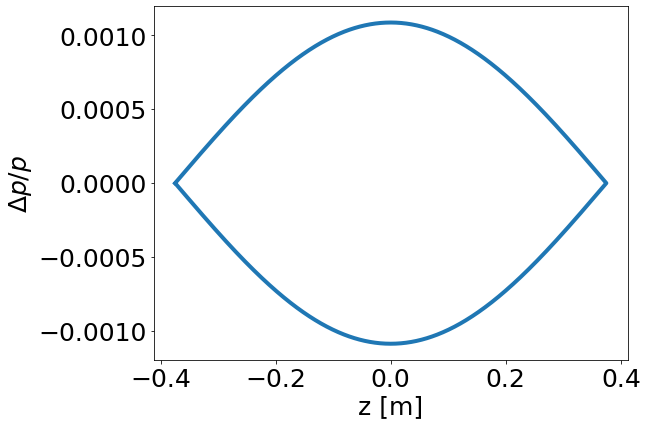

In [191]:
step = 0.001
z_list = []
delta_list = []

for zi in np.arange(z_left , z_right , step):
    delta_list.append(np.sqrt(V_RF * (np.cos(h * zi * 2 * np.pi / C0) + 1.) / (np.pi * h * abs(eta) * beta_0 * P0)))
    z_list.append(zi)
                      
for zi in np.arange(z_right, z_left , -step):
    delta_list.append(-np.sqrt(V_RF * (np.cos(h * zi * 2 * np.pi / C0) + 1.) / (np.pi * h * abs(eta) * beta_0 * P0)))
    z_list.append(zi)
                      
plt.plot(z_list, delta_list, linewidth =4)
plt.xlabel('z [m]')
plt.ylabel(r'$\Delta p / p$')

plt.show()


### Create the bunch 
Gaussian distribution 

In [195]:
# create bunch
bunch = DottedDict()
bunch.z = np.zeros(n_particles)
bunch.delta = np.zeros(n_particles)
mu, sigma = 0.0, 1 # mean and standard deviation


sigma_t = 0.075 # bunch length in [m], MAD-X for HL-LHC : cernbox/2019/7/HL_LH_mask_emilia.ipynb 
sigma_e = 0.00011 #[m] relative energy spreead sigma_e/E  [2.5 in eVs for LHC at 7 TeV]   

z_initial = np.random.normal(mu, sigma, n_particles)*sigma_t
delta_initial = np.random.normal(mu, sigma, n_particles)*sigma_e


bunch.z = z_initial
bunch.delta = delta_initial

In [196]:
bunch.z = z_initial
bunch.delta = delta_initial
df = pd.DataFrame({'turn':[], 'z':[], 'delta':[], 'y':[], 'py':[]})
# Append the initial values, not normalised
df = df.append({'turn':0, 'z':bunch.z, 'delta':bunch.delta}, ignore_index = True)

### Tracking and plotting of the phase space

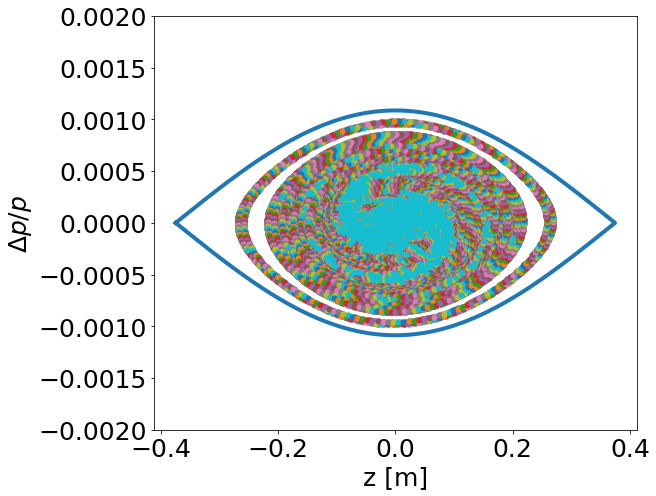

In [197]:
fig, ax = plt.subplots(1,1,figsize=(9,7))


for turn in range(0, 1000): #plot for the first 10 turns
    ax.scatter(bunch.z, bunch.delta)
    ax.set_xlabel('z [m]')
    ax.set_ylabel(r'$\Delta p /p$')
    bunch.z, bunch.delta = drift(eta, alpha_c, C0, bunch.z, bunch.delta)
    bunch.z, bunch.delta = RF_map(P0, m0, beta_0, f_RF, c, lag, V_RF, E_0, bunch.z, bunch.delta)
    
    df = df.append({'turn':turn, 'z':bunch.z, 'delta':bunch.delta}, ignore_index = True)
                      
plt.plot(z_list,delta_list, linewidth = 4)

plt.ylim(-2e-3, 2e-3)
plt.tight_layout()
df.to_pickle('my_data_frame.pkl')

### Calculate synchtotron tune
- Theoretically it should be :
\begin{equation}
Q_s = \sqrt{\frac{2 \pi h \eta V_{RF}}{Ε}} f_{rev}
\end{equation}

In [200]:
Q_s  = np.sqrt(2*np.pi*h*eta*V_RF/E_0)*f_rev_0

Q_s something is wrong, i though Qs would be 0.2 or sthg

In [203]:
Q_s

473.2023032656167